# Imports

In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import copy
from scipy.stats import trim_mean

from minot.ClusterTools import map_tools
import pitszi

import macsj0717_libs as libs

sigma2fwhm = 2 * np.sqrt(2*np.log(2))

# Parameters

In [2]:
outdir = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/RadialFitInducedFiltering/'

#----- Cluster parameters
cl_redshift = 0.546
cl_M500     = 25*1e14*u.Msun
cl_coord    = SkyCoord(109.3870*u.deg, 37.7525*u.deg, frame='icrs')

#----- ICM model parameters
Linj = 750*u.kpc
Norm = 0.5
ell_q = 1
Pmod = 'A10MD'

#----- Sampling
reso = 4*u.arcsec
FoV = 4*u.arcmin
los_reso = 30*u.kpc
los_size = 8*u.Mpc

#----- Pk binning
Nbins_pk = 30
scale_bins = 'lin'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(18.2*u.arcsec)

#----- Analysis parameters
mask_theta = 1.5*u.arcmin
apply_radial_model = True
remove_GNFW_core = True
smw = 40*u.arcsec

Nsim = 1000
Nmc = 10

In [3]:
fitpar_prof1 = {
    'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
    'ZL':{'guess':[0,1e-5],'unit':None},
}

fitpar_prof2 = {
    'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
    'RA': {'guess':[cl_coord.ra.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.ra.to_value('deg')-0.5/60, cl_coord.ra.to_value('deg')+0.5/60]},
    'Dec': {'guess':[cl_coord.dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.dec.to_value('deg')-0.5/60, cl_coord.dec.to_value('deg')+0.5/60]},
    'ZL':{'guess':[0,1e-5],'unit':None},
}

fitpar_prof3 = {
    'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
    'RA': {'guess':[cl_coord.ra.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.ra.to_value('deg')-0.5/60, cl_coord.ra.to_value('deg')+0.5/60]},
    'Dec': {'guess':[cl_coord.dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.dec.to_value('deg')-0.5/60, cl_coord.dec.to_value('deg')+0.5/60]},
    'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
    'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
    'ZL':{'guess':[0,1e-5],'unit':None},
}

fitpar_prof4 = {
    'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
    'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
    'RA': {'guess':[cl_coord.ra.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.ra.to_value('deg')-0.5/60, cl_coord.ra.to_value('deg')+0.5/60]},
    'Dec': {'guess':[cl_coord.dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.dec.to_value('deg')-0.5/60, cl_coord.dec.to_value('deg')+0.5/60]},
    'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
    'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
    'ZL':{'guess':[0,1e-5],'unit':None},
}

fitpar_prof5 = {
    'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
    'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
    'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
    'b': {'guess':[5, 0.5], 'unit': None, 'limit':[2, 8]},
    'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[0, 2]},
    'RA': {'guess':[cl_coord.ra.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.ra.to_value('deg')-0.5/60, cl_coord.ra.to_value('deg')+0.5/60]},
    'Dec': {'guess':[cl_coord.dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[cl_coord.dec.to_value('deg')-0.5/60, cl_coord.dec.to_value('deg')+0.5/60]},
    'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
    'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
    'ZL':{'guess':[0,1e-5],'unit':None},
}

In [4]:
#===== Instrument parameters
beam_FWHM = 18.2*u.arcsec
TF        = libs.get_TF()

In [5]:
#===== Get the data
cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(FoV, reso, 1000)

# Model

In [6]:
#========== cluster model
cl_model = pitszi.Model(name='Model', RA=cl_coord.ra, Dec=cl_coord.dec, 
                        redshift=cl_redshift, M500=cl_M500, 
                        silent=True, output_dir=outdir)
cl_model.set_pressure_profile_universal_param(Pmod)
cl_model.triaxiality = {'min_to_maj_axis_ratio':ell_q, 'int_to_maj_axis_ratio':ell_q,
                        'euler_angle1':0*u.deg, 'euler_angle2':90*u.deg, 'euler_angle3':0*u.deg}
cl_model.model_pressure_fluctuation = {'name':'CutoffPowerLaw',
                                      'statistics':'lognormal',
                                      'Ldis':1*u.kpc,
                                      'Linj':Linj,
                                      'Norm':Norm,
                                      'slope':-11.0/3}
cl_model.map_header   = cl_head
cl_model.los_reso     = los_reso
cl_model.los_size     = los_size
cl_model.R_truncation = 10*u.Mpc

# Analysis

In [7]:
pk0mcA = np.zeros((Nmc, Nbins_pk))
pk1mcA = np.zeros((Nmc, Nbins_pk))
pk2mcA = np.zeros((Nmc, Nbins_pk))
pk3mcA = np.zeros((Nmc, Nbins_pk))
pk4mcA = np.zeros((Nmc, Nbins_pk))
pk5mcA = np.zeros((Nmc, Nbins_pk))

-----  1 / 10
-----  2 / 10
-----  3 / 10
-----  4 / 10
-----  5 / 10
-----  6 / 10
-----  7 / 10
-----  8 / 10
-----  9 / 10
-----  10 / 10


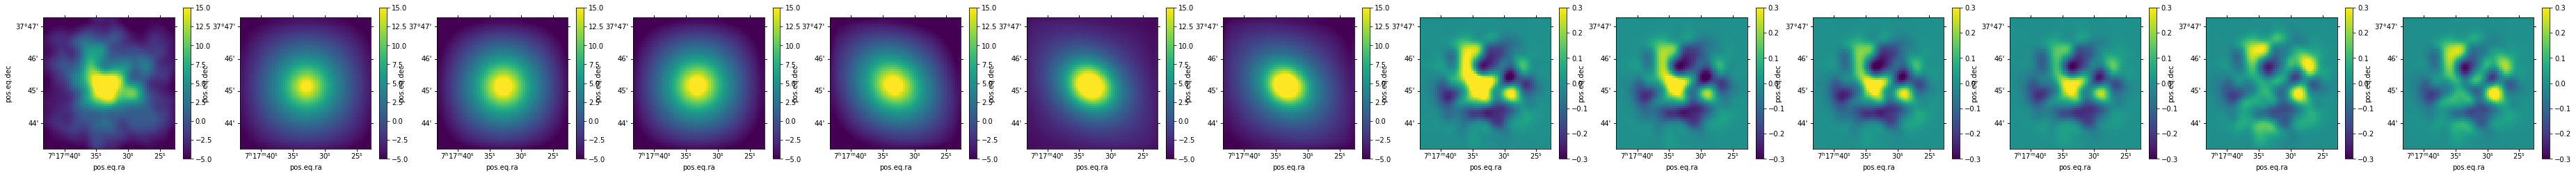

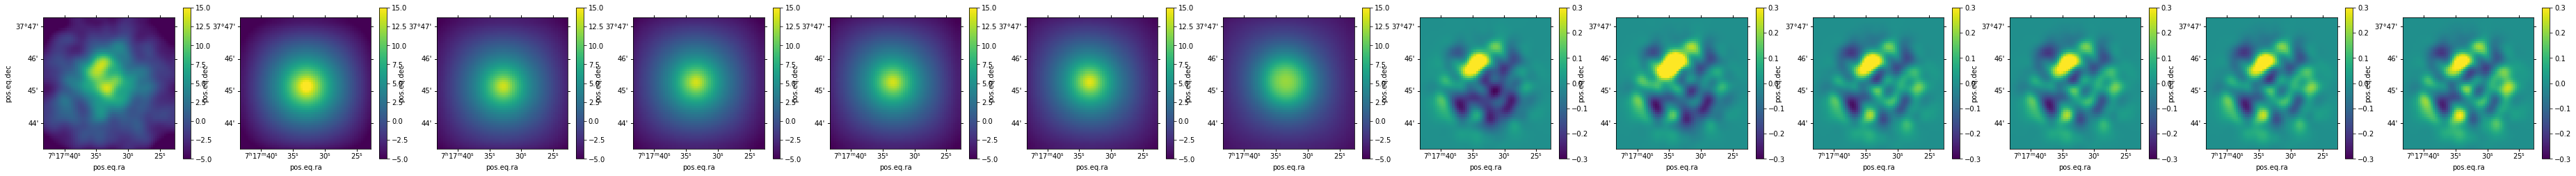

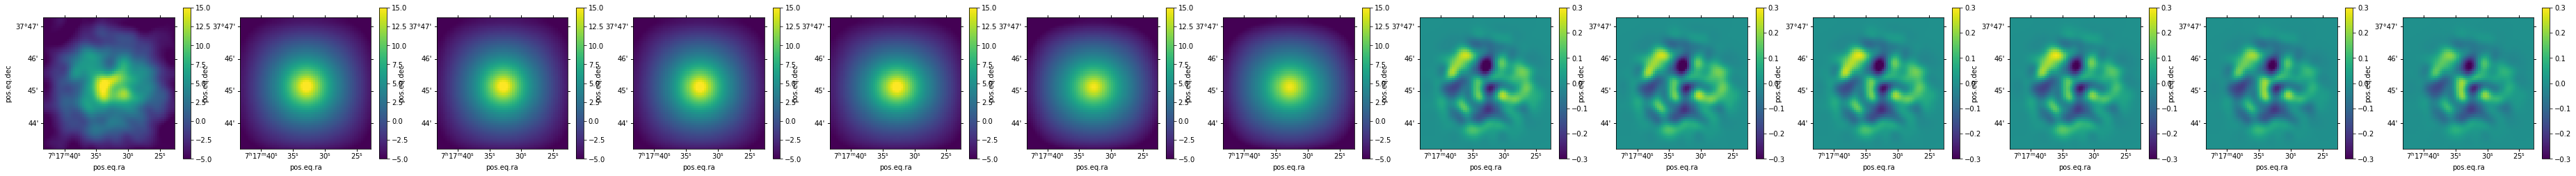

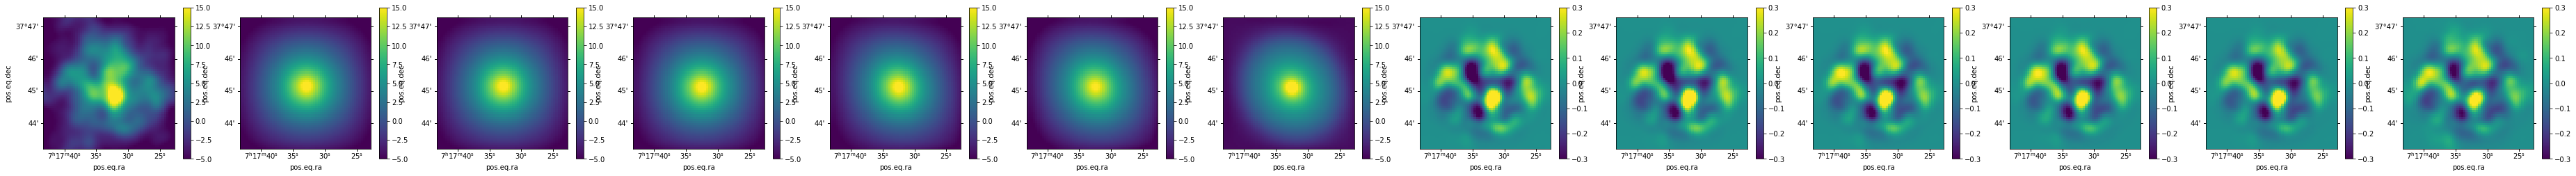

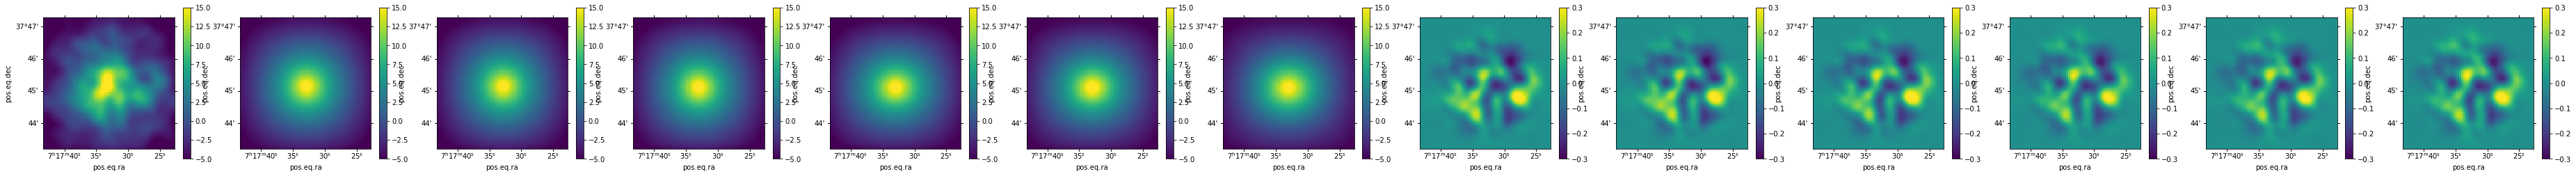

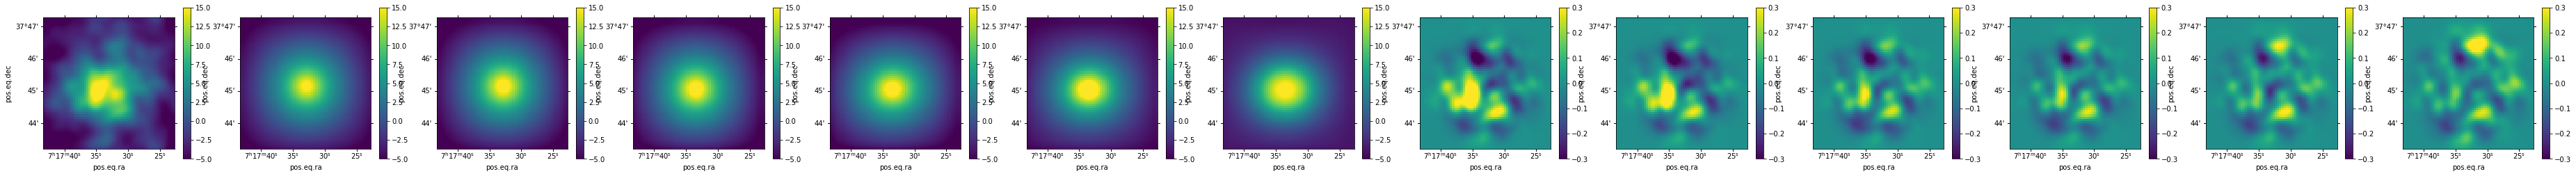

In [8]:
noise_scale = 1e-2

#===== Loop over the simulations
for i in range(Nmc):
    print('----- ', i+1, '/', Nmc)
    
    #----- Generate data
    cl_img = cl_model.get_sz_map(irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF) #+ cl_noise[i]*noise_scale
    cl_data = libs.def_data(cl_img, cl_head, cl_noise, cl_mask, beam_FWHM, TF, outdir, Nsim)
    #cl_data.noise_rms *= noise_scale
    
    #----- Fit the profile data
    cl_Rinfer1 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir=outdir)
    _ = cl_Rinfer1.run_curvefit_profile(fitpar_prof1, show_fit_result=False, set_bestfit=True)
    cl_Rinfer2 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir=outdir)
    _ = cl_Rinfer2.run_curvefit_profile(fitpar_prof2, show_fit_result=False, set_bestfit=True)
    cl_Rinfer3 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir=outdir)
    _ = cl_Rinfer3.run_curvefit_profile(fitpar_prof3, show_fit_result=False, set_bestfit=True)
    cl_Rinfer4 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir=outdir)
    _ = cl_Rinfer4.run_curvefit_profile(fitpar_prof4, show_fit_result=False, set_bestfit=True)
    cl_Rinfer5 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=True, output_dir=outdir)
    _ = cl_Rinfer5.run_curvefit_profile(fitpar_prof5, show_fit_result=False, set_bestfit=True)
        
    #----- Compute the ROI
    roi0 = libs.def_roi(cl_head, cl_model, mask_theta=mask_theta, show=False)
    roi1 = libs.def_roi(cl_head, cl_Rinfer1.model, mask_theta=mask_theta, show=False)
    roi2 = libs.def_roi(cl_head, cl_Rinfer2.model, mask_theta=mask_theta, show=False)
    roi3 = libs.def_roi(cl_head, cl_Rinfer3.model, mask_theta=mask_theta, show=False)
    roi4 = libs.def_roi(cl_head, cl_Rinfer4.model, mask_theta=mask_theta, show=False)
    roi5 = libs.def_roi(cl_head, cl_Rinfer5.model, mask_theta=mask_theta, show=False)
    
    #----- Pk inference definition
    cl_Finfer0 = pitszi.InferenceFluctuation(cl_data, cl_model, 
                                             kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                             output_dir=outdir, silent=True)
    cl_Finfer1 = pitszi.InferenceFluctuation(cl_data, cl_Rinfer1.model, 
                                             kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                             output_dir=outdir, silent=True)
    cl_Finfer2 = pitszi.InferenceFluctuation(cl_data, cl_Rinfer2.model, 
                                             kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                             output_dir=outdir, silent=True)
    cl_Finfer3 = pitszi.InferenceFluctuation(cl_data, cl_Rinfer3.model, 
                                             kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                             output_dir=outdir, silent=True)
    cl_Finfer4 = pitszi.InferenceFluctuation(cl_data, cl_Rinfer4.model, 
                                             kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                             output_dir=outdir, silent=True)
    cl_Finfer5 = pitszi.InferenceFluctuation(cl_data, cl_Rinfer5.model, 
                                             kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                             output_dir=outdir, silent=True)
        
    #----- Weight definition
    cl_Finfer0.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
                         conv_radial_model_beam=True, conv_radial_model_TF=False, 
                         remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
    #cl_Finfer1.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
    #                     conv_radial_model_beam=True, conv_radial_model_TF=False, 
    #                     remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
    #cl_Finfer2.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
    #                     conv_radial_model_beam=True, conv_radial_model_TF=False, 
    #                     remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
    #cl_Finfer3.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
    #                     conv_radial_model_beam=True, conv_radial_model_TF=False, 
    #                     remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
    #cl_Finfer4.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
    #                     conv_radial_model_beam=True, conv_radial_model_TF=False, 
    #                     remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
    #cl_Finfer5.set_method_w8(roi_mask=roi0, apply_radial_model=apply_radial_model, 
    #                     conv_radial_model_beam=True, conv_radial_model_TF=False, 
    #                     remove_GNFW_core=remove_GNFW_core, smooth_FWHM=smw, normalize=True)
    cl_Finfer1.method_w8 = cl_Finfer0.method_w8
    cl_Finfer2.method_w8 = cl_Finfer0.method_w8
    cl_Finfer3.method_w8 = cl_Finfer0.method_w8
    cl_Finfer4.method_w8 = cl_Finfer0.method_w8
    cl_Finfer5.method_w8 = cl_Finfer0.method_w8
    
    #----- Setup
    cl_Finfer0.pk_setup(1)
    cl_Finfer1.pk_setup(1)
    cl_Finfer2.pk_setup(1)
    cl_Finfer3.pk_setup(1)
    cl_Finfer4.pk_setup(1)
    cl_Finfer5.pk_setup(1)
    
    #----- Results
    pk0mcA[i,:] = cl_Finfer0._pk2d_data
    pk1mcA[i,:] = cl_Finfer1._pk2d_data
    pk2mcA[i,:] = cl_Finfer2._pk2d_data
    pk3mcA[i,:] = cl_Finfer3._pk2d_data
    pk4mcA[i,:] = cl_Finfer4._pk2d_data
    pk5mcA[i,:] = cl_Finfer5._pk2d_data
    
    if i == 0:
        cl_Finfer0.nuisance_Anoise = 0
        cl_Finfer0.nuisance_Abkg = 0
        kref, pkref = cl_Finfer0.get_pk2d_model_proj(True)
        
        pkref /= cl_Finfer0._conv_pk2d3d
    pk0mcA[i,:] /= cl_Finfer0._conv_pk2d3d
    pk1mcA[i,:] /= cl_Finfer1._conv_pk2d3d
    pk2mcA[i,:] /= cl_Finfer2._conv_pk2d3d
    pk3mcA[i,:] /= cl_Finfer3._conv_pk2d3d
    pk4mcA[i,:] /= cl_Finfer4._conv_pk2d3d
    pk5mcA[i,:] /= cl_Finfer5._conv_pk2d3d
        
    #----- Show the last realization for check
    if i <= 5:
        fig = plt.figure(i, figsize=(65, 4))
            
        ax = plt.subplot(1, 13, 1, projection=WCS(cl_head))
        plt.imshow(cl_Finfer1.data1.image*1e5, vmin=-5, vmax=15)
        plt.colorbar()
        
        ax = plt.subplot(1, 13, 2, projection=WCS(cl_head))
        plt.imshow(cl_Finfer0._ymap_sphA1*1e5, vmin=-5, vmax=15)
        plt.colorbar()
        
        ax = plt.subplot(1, 13, 3, projection=WCS(cl_head))
        plt.imshow(cl_Finfer1._ymap_sphA1*1e5, vmin=-5, vmax=15)
        plt.colorbar()
        
        ax = plt.subplot(1, 13, 4, projection=WCS(cl_head))
        plt.imshow(cl_Finfer2._ymap_sphA1*1e5, vmin=-5, vmax=15)
        plt.colorbar()
        
        ax = plt.subplot(1, 13, 5, projection=WCS(cl_head))
        plt.imshow(cl_Finfer3._ymap_sphA1*1e5, vmin=-5, vmax=15)
        plt.colorbar()
        
        ax = plt.subplot(1, 13, 6, projection=WCS(cl_head))
        plt.imshow(cl_Finfer4._ymap_sphA1*1e5, vmin=-5, vmax=15)
        plt.colorbar()

        ax = plt.subplot(1, 13, 7, projection=WCS(cl_head))
        plt.imshow(cl_Finfer5._ymap_sphA1*1e5, vmin=-5, vmax=15)
        plt.colorbar()
        
        ax = plt.subplot(1, 13, 8, projection=WCS(cl_head))
        plt.imshow(cl_Finfer0._dy_image1, vmin=-0.3, vmax=0.3)
        plt.colorbar()
        
        ax = plt.subplot(1, 13, 9, projection=WCS(cl_head))
        plt.imshow(cl_Finfer1._dy_image1 * cl_Finfer0._conv_pk2d3d/cl_Finfer1._conv_pk2d3d, vmin=-0.3, vmax=0.3)
        plt.colorbar()
        
        ax = plt.subplot(1, 13, 10, projection=WCS(cl_head))
        plt.imshow(cl_Finfer2._dy_image1 * cl_Finfer0._conv_pk2d3d/cl_Finfer2._conv_pk2d3d, vmin=-0.3, vmax=0.3)
        plt.colorbar()

        ax = plt.subplot(1, 13, 11, projection=WCS(cl_head))
        plt.imshow(cl_Finfer3._dy_image1 * cl_Finfer0._conv_pk2d3d/cl_Finfer3._conv_pk2d3d, vmin=-0.3, vmax=0.3)
        plt.colorbar()
        
        ax = plt.subplot(1, 13, 12, projection=WCS(cl_head))
        plt.imshow(cl_Finfer4._dy_image1 * cl_Finfer0._conv_pk2d3d/cl_Finfer4._conv_pk2d3d, vmin=-0.3, vmax=0.3)
        plt.colorbar()
        
        ax = plt.subplot(1, 13, 13, projection=WCS(cl_head))
        plt.imshow(cl_Finfer5._dy_image1 * cl_Finfer0._conv_pk2d3d/cl_Finfer5._conv_pk2d3d, vmin=-0.3, vmax=0.3)
        plt.colorbar()

In [9]:
try:
    ldata = np.load(outdir+'saved_simulation.npy')
    pk0mcB = ldata[0]
    pk1mcB = ldata[1]
    pk2mcB = ldata[2]
    pk3mcB = ldata[3]
    pk4mcB = ldata[4]
    pk5mcB = ldata[5]

    pk0mc = np.append(pk0mcB, pk0mcA, axis=0)
    pk1mc = np.append(pk1mcB, pk1mcA, axis=0)
    pk2mc = np.append(pk2mcB, pk2mcA, axis=0)
    pk3mc = np.append(pk3mcB, pk3mcA, axis=0)
    pk4mc = np.append(pk4mcB, pk4mcA, axis=0)
    pk5mc = np.append(pk5mcB, pk5mcA, axis=0)
    
    Nmc_available = pk0mc.shape[0]
except:
    print('Initial data not found')
    pk0mc = pk0mcA
    pk1mc = pk1mcA
    pk2mc = pk2mcA
    pk3mc = pk3mcA
    pk4mc = pk4mcA
    pk5mc = pk5mcA
    
    Nmc_available = Nmc
    
np.save(outdir+'saved_simulation.npy', [pk0mc,pk1mc,pk2mc,pk3mc,pk4mc,pk5mc]) 

print('Number of total MC realization:', Nmc_available)

Number of total MC realization: 100


Text(0.5, 0, 'k')

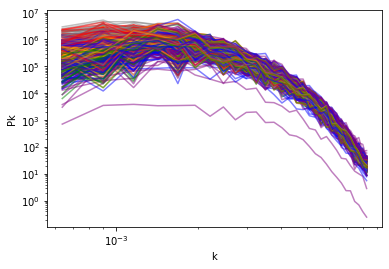

In [10]:
plt.loglog(kref, pkref, color='k')
for i in range(Nmc_available):
    plt.loglog(kref, pk0mc[i], color='grey', alpha=0.5)
    plt.loglog(kref, pk1mc[i], color='red', alpha=0.5)
    plt.loglog(kref, pk2mc[i], color='orange', alpha=0.5)
    plt.loglog(kref, pk3mc[i], color='green', alpha=0.5)
    plt.loglog(kref, pk4mc[i], color='blue', alpha=0.5)
    plt.loglog(kref, pk5mc[i], color='purple', alpha=0.5)
plt.ylabel('Pk')
plt.xlabel('k')

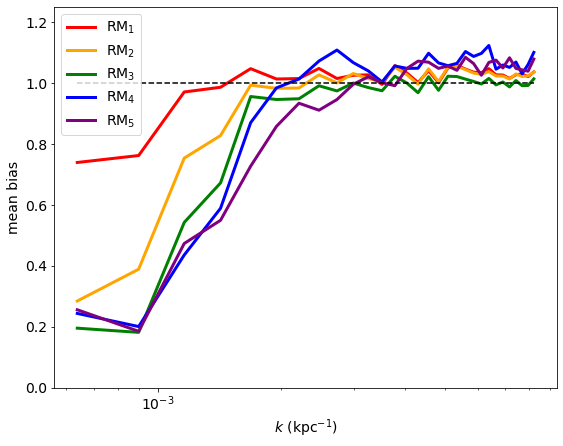

In [14]:
trim = 0.3
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(9, 7))
#for i in range(Nmc_available):
#    plt.plot(kref, pk1mc[i]/pk0mc[i], color='red', alpha=0.1)
#    plt.plot(kref, pk2mc[i]/pk0mc[i], color='orange', alpha=0.1)
#    plt.plot(kref, pk3mc[i]/pk0mc[i], color='green', alpha=0.1)
#    plt.plot(kref, pk4mc[i]/pk0mc[i], color='blue', alpha=0.1)
#    plt.plot(kref, pk5mc[i]/pk0mc[i], color='purple', alpha=0.1)
plt.plot(kref, trim_mean(pk1mc, trim, axis=0) / trim_mean(pk0mc, trim, axis=0), color='red',    lw=3, label='RM$_1$')
plt.plot(kref, trim_mean(pk2mc, trim, axis=0) / trim_mean(pk0mc, trim, axis=0), color='orange', lw=3, label='RM$_2$')
plt.plot(kref, trim_mean(pk3mc, trim, axis=0) / trim_mean(pk0mc, trim, axis=0), color='green',  lw=3, label='RM$_3$')
plt.plot(kref, trim_mean(pk4mc, trim, axis=0) / trim_mean(pk0mc, trim, axis=0), color='blue',   lw=3, label='RM$_4$')
plt.plot(kref, trim_mean(pk5mc, trim, axis=0) / trim_mean(pk0mc, trim, axis=0), color='purple', lw=3, label='RM$_5$')
#plt.plot(kref, trim_mean(pk1mc/pk0mc, 0.3, axis=0), color='red',    lw=3, ls='--', label='RM$_1$')
#plt.plot(kref, trim_mean(pk2mc/pk0mc, 0.3, axis=0), color='orange', lw=3, ls='--', label='RM$_2$')
#plt.plot(kref, trim_mean(pk3mc/pk0mc, 0.3, axis=0), color='green',  lw=3, ls='--', label='RM$_3$')
#plt.plot(kref, trim_mean(pk4mc/pk0mc, 0.3, axis=0), color='blue',   lw=3, ls='--', label='RM$_4$')
#plt.plot(kref, trim_mean(pk5mc/pk0mc, 0.3, axis=0), color='purple', lw=3, ls='--', label='RM$_5$')
plt.yscale('linear')
plt.xscale('log')
plt.ylim(0,1.25)
plt.hlines(1, np.amin(kref.value), np.amax(kref.value), color='k', ls='--')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.ylabel(r'mean bias')
plt.legend()
plt.savefig(outdir+'Bias_induced_radial_fit.pdf')